## Test Model 2030

In [14]:
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
from pypsa.plot import add_legend_patches
import gurobipy
import cartopy.crs as ccrs

#pd.set_option("display.max_rows", None)  # Display all rows
#pd.set_option("display.max_columns", None)  # Display all columns


## Import Network

In [15]:
n = pypsa.Network("C:\\Users\\Jeremy\\Documents\\MasterThesis\\Models\\20240309\\elec_s_37_ec_lv1.5_Co2L-3h.nc")


INFO:pypsa.io:Imported network elec_s_37_ec_lv1.5_Co2L-3h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [16]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 111 entries
Component 'Carrier' has 24 entries
Component 'GlobalConstraint' has 2 entries
Component 'Line' has 52 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 191 entries
Component 'Load' has 37 entries
Component 'Generator' has 449 entries
Component 'StorageUnit' has 50 entries
Component 'Store' has 74 entries


In [113]:
n.lines.s_nom_opt

Line
0     1.000000e+10
1     1.000000e+10
10    1.000001e+10
11    1.000000e+10
12    1.000000e+10
13    2.500009e+09
14    1.000000e+10
15    1.000001e+10
16    2.500002e+09
17    1.000000e+10
18    1.000001e+10
19    1.000000e+10
2     1.000000e+10
20    2.500027e+09
21    1.000001e+10
22    2.500008e+09
23    2.500007e+09
24    1.000000e+10
25    1.000001e+10
26    2.500004e+09
27    2.500009e+09
28    1.000000e+10
29    1.000001e+10
3     1.000000e+10
30    2.500007e+09
31    2.500003e+09
32    1.000000e+10
33    1.250004e+09
34    2.500015e+09
35    2.500003e+09
36    2.500006e+09
37    1.000000e+10
38    1.000000e+10
39    1.000001e+10
4     2.500007e+09
40    1.000000e+10
41    1.000001e+10
42    2.500003e+09
43    1.000000e+10
44    1.000000e+10
45    1.000000e+10
46    1.000000e+10
47    1.000000e+10
48    1.000000e+10
49    1.000001e+10
5     1.000000e+10
50    1.000000e+10
51    1.000001e+10
6     2.500016e+09
7     1.000000e+10
8     2.500000e+09
9     1.000000e+10
Name: s

## Plot Network

<function matplotlib.pyplot.show(close=None, block=None)>

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


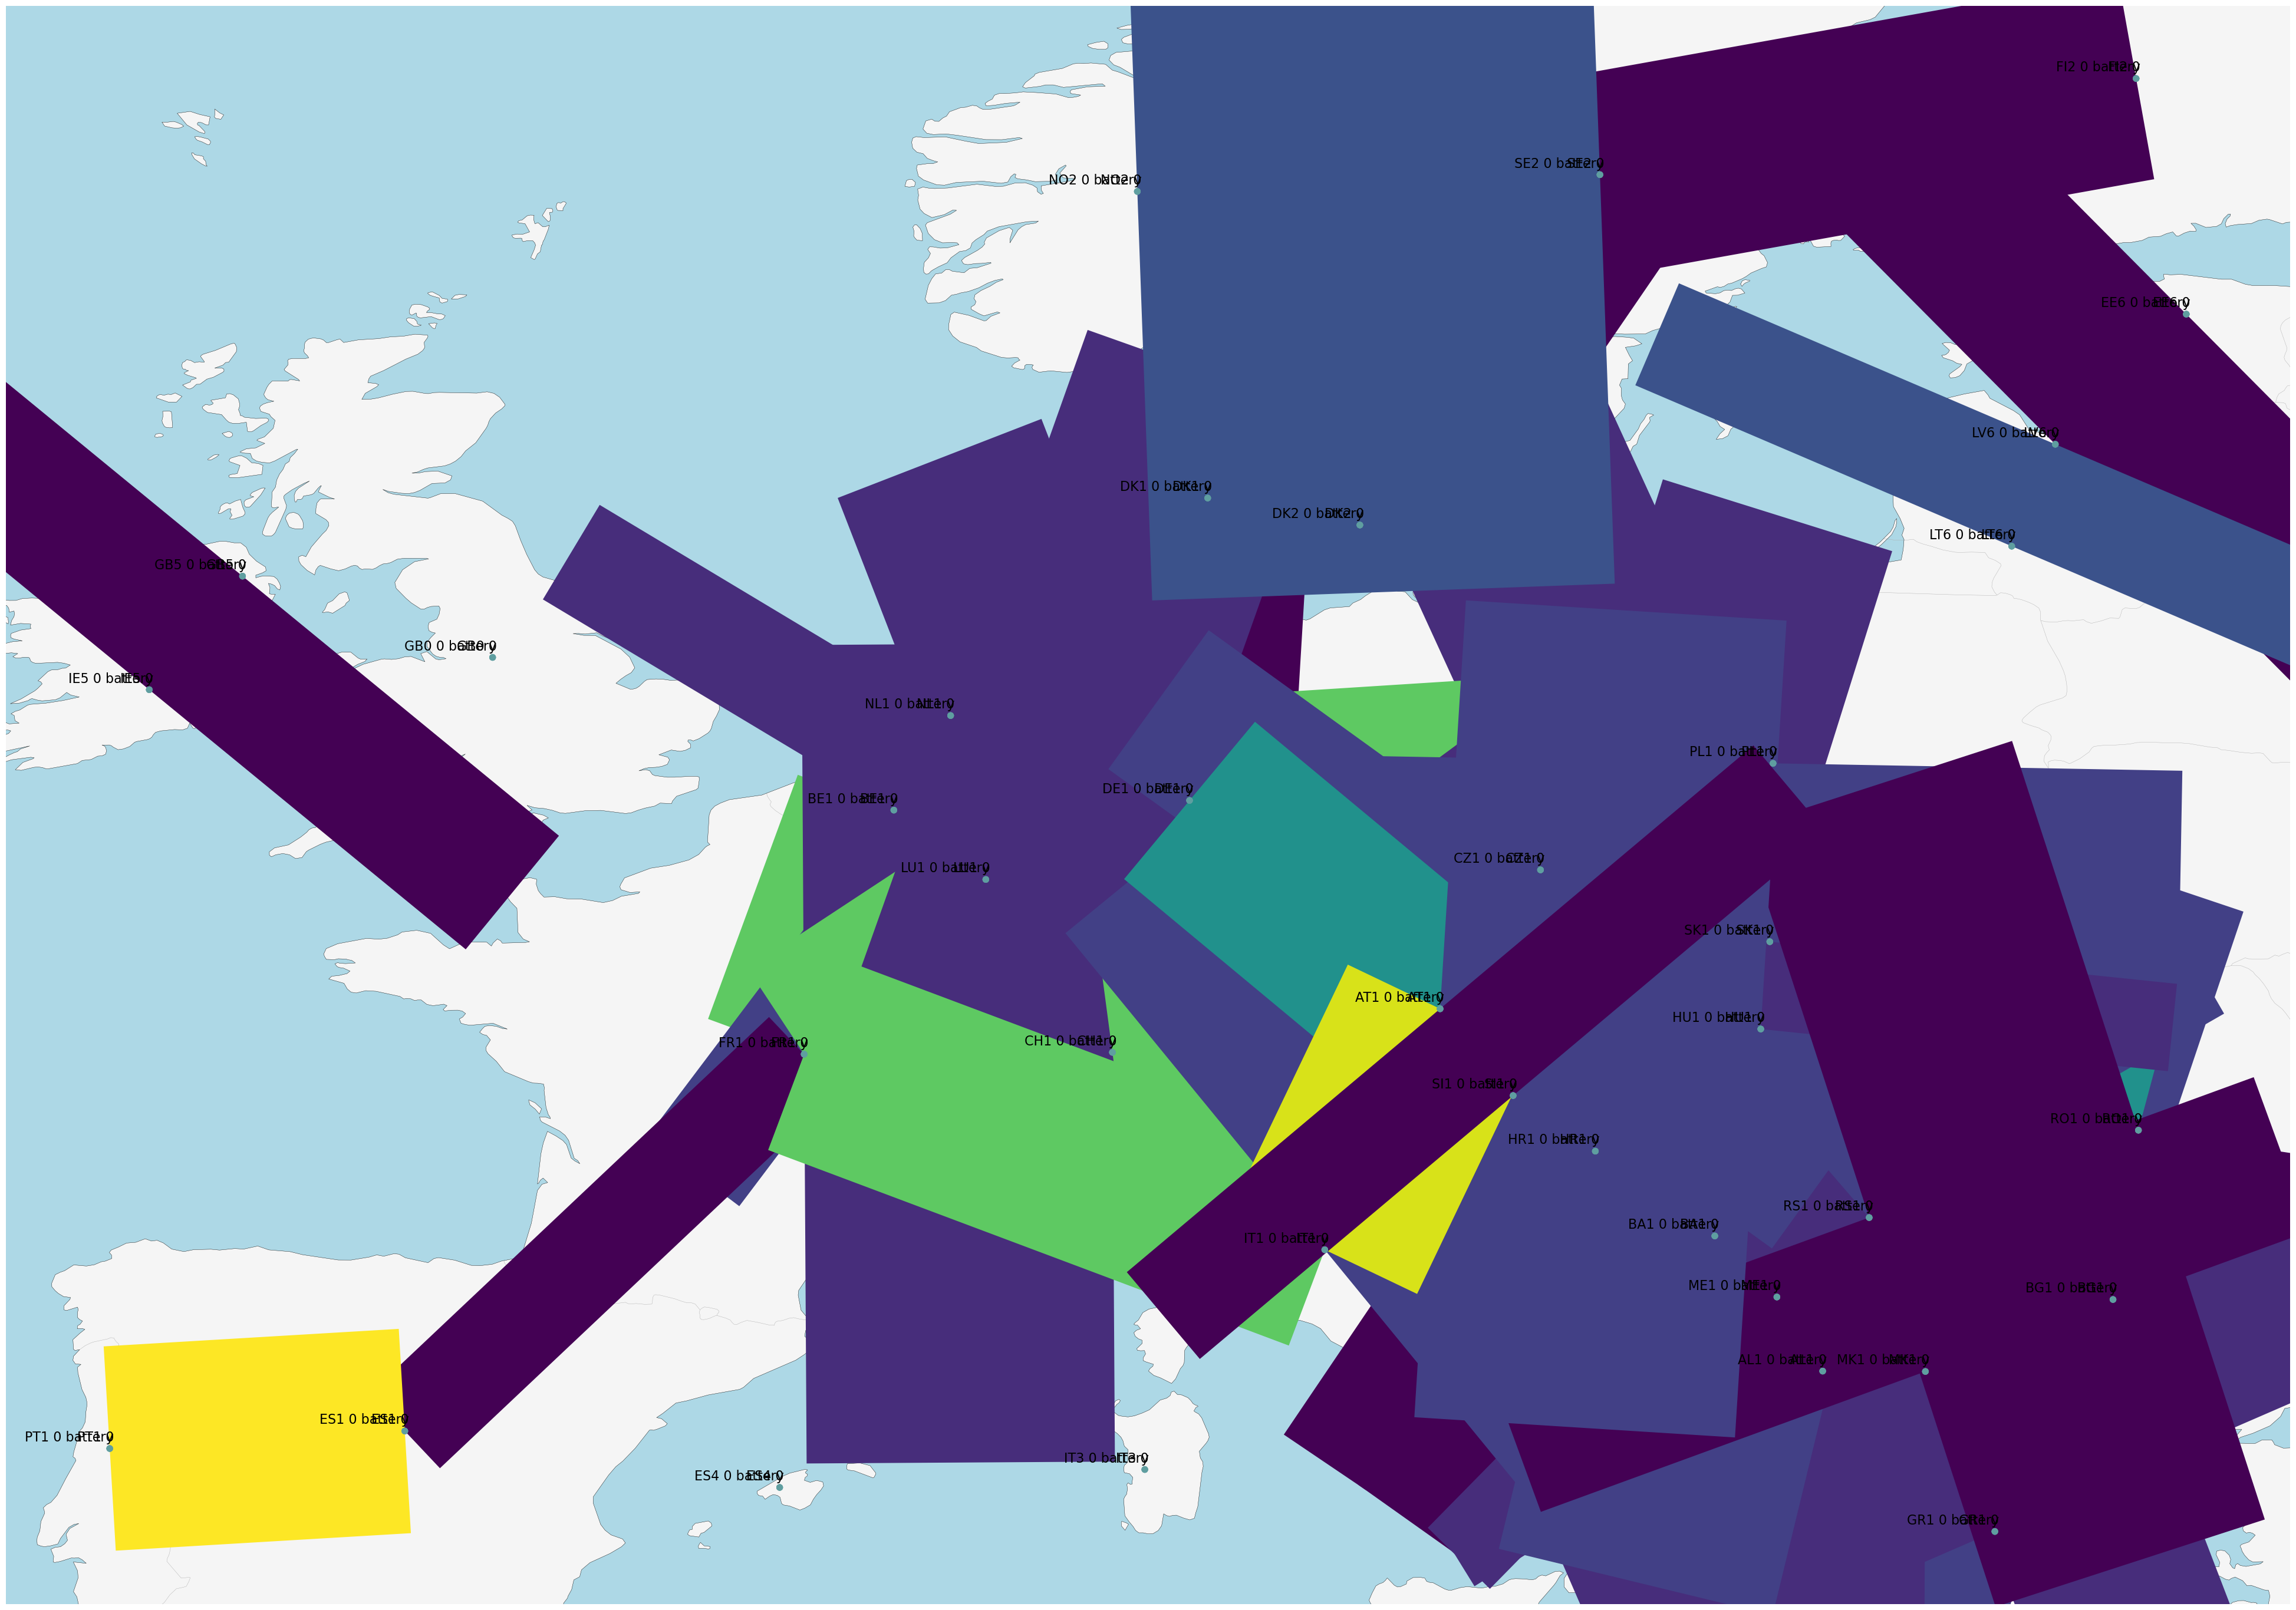

In [96]:
loading = (n.lines_t.p0.abs().mean().sort_index()/(n.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

fig, ax = plt.subplots(
    figsize=(50,50),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

n.plot(
    ax=ax,
    branch_components=["Line"],
    line_widths=n.lines.s_nom_opt/1e7, #GW
    line_colors=loading,
    line_cmap=plt.cm.viridis,
    color_geomap=True,
    bus_sizes=0.003
)

bus = n.buses
region = []
for index, row in bus.iterrows():
    x = row['x']
    y = row['y']
    if "H2" in index:
        pass
    else:
        region.append(index)
        ax.annotate(
        index,
        xy=(x, y),
        xytext=(5, 5),  # Adjust the position of the annotation
        textcoords="offset points",
        ha='right', va='bottom'
    )

plt.show





## Installed Capcity

In [19]:
def inst_cap_plot():

    capacities = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()

    plt.rcParams.update({'font.size': 16})

    fig = plt.figure(figsize=(50,50))
    ax = plt.axes(projection=ccrs.PlateCarree())

    n.plot(
        ax=ax,
        margin=0.3,
        bus_sizes= capacities / 1e11,
        title=f"Installed power capacities"
    )

    add_legend_patches(
        ax,
        n.carriers.color,
        n.carriers.index,
        legend_kw=dict(frameon=False, bbox_to_anchor=(0,1))
    )

    return capacities

ValueError: Invalid RGBA argument: ''

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


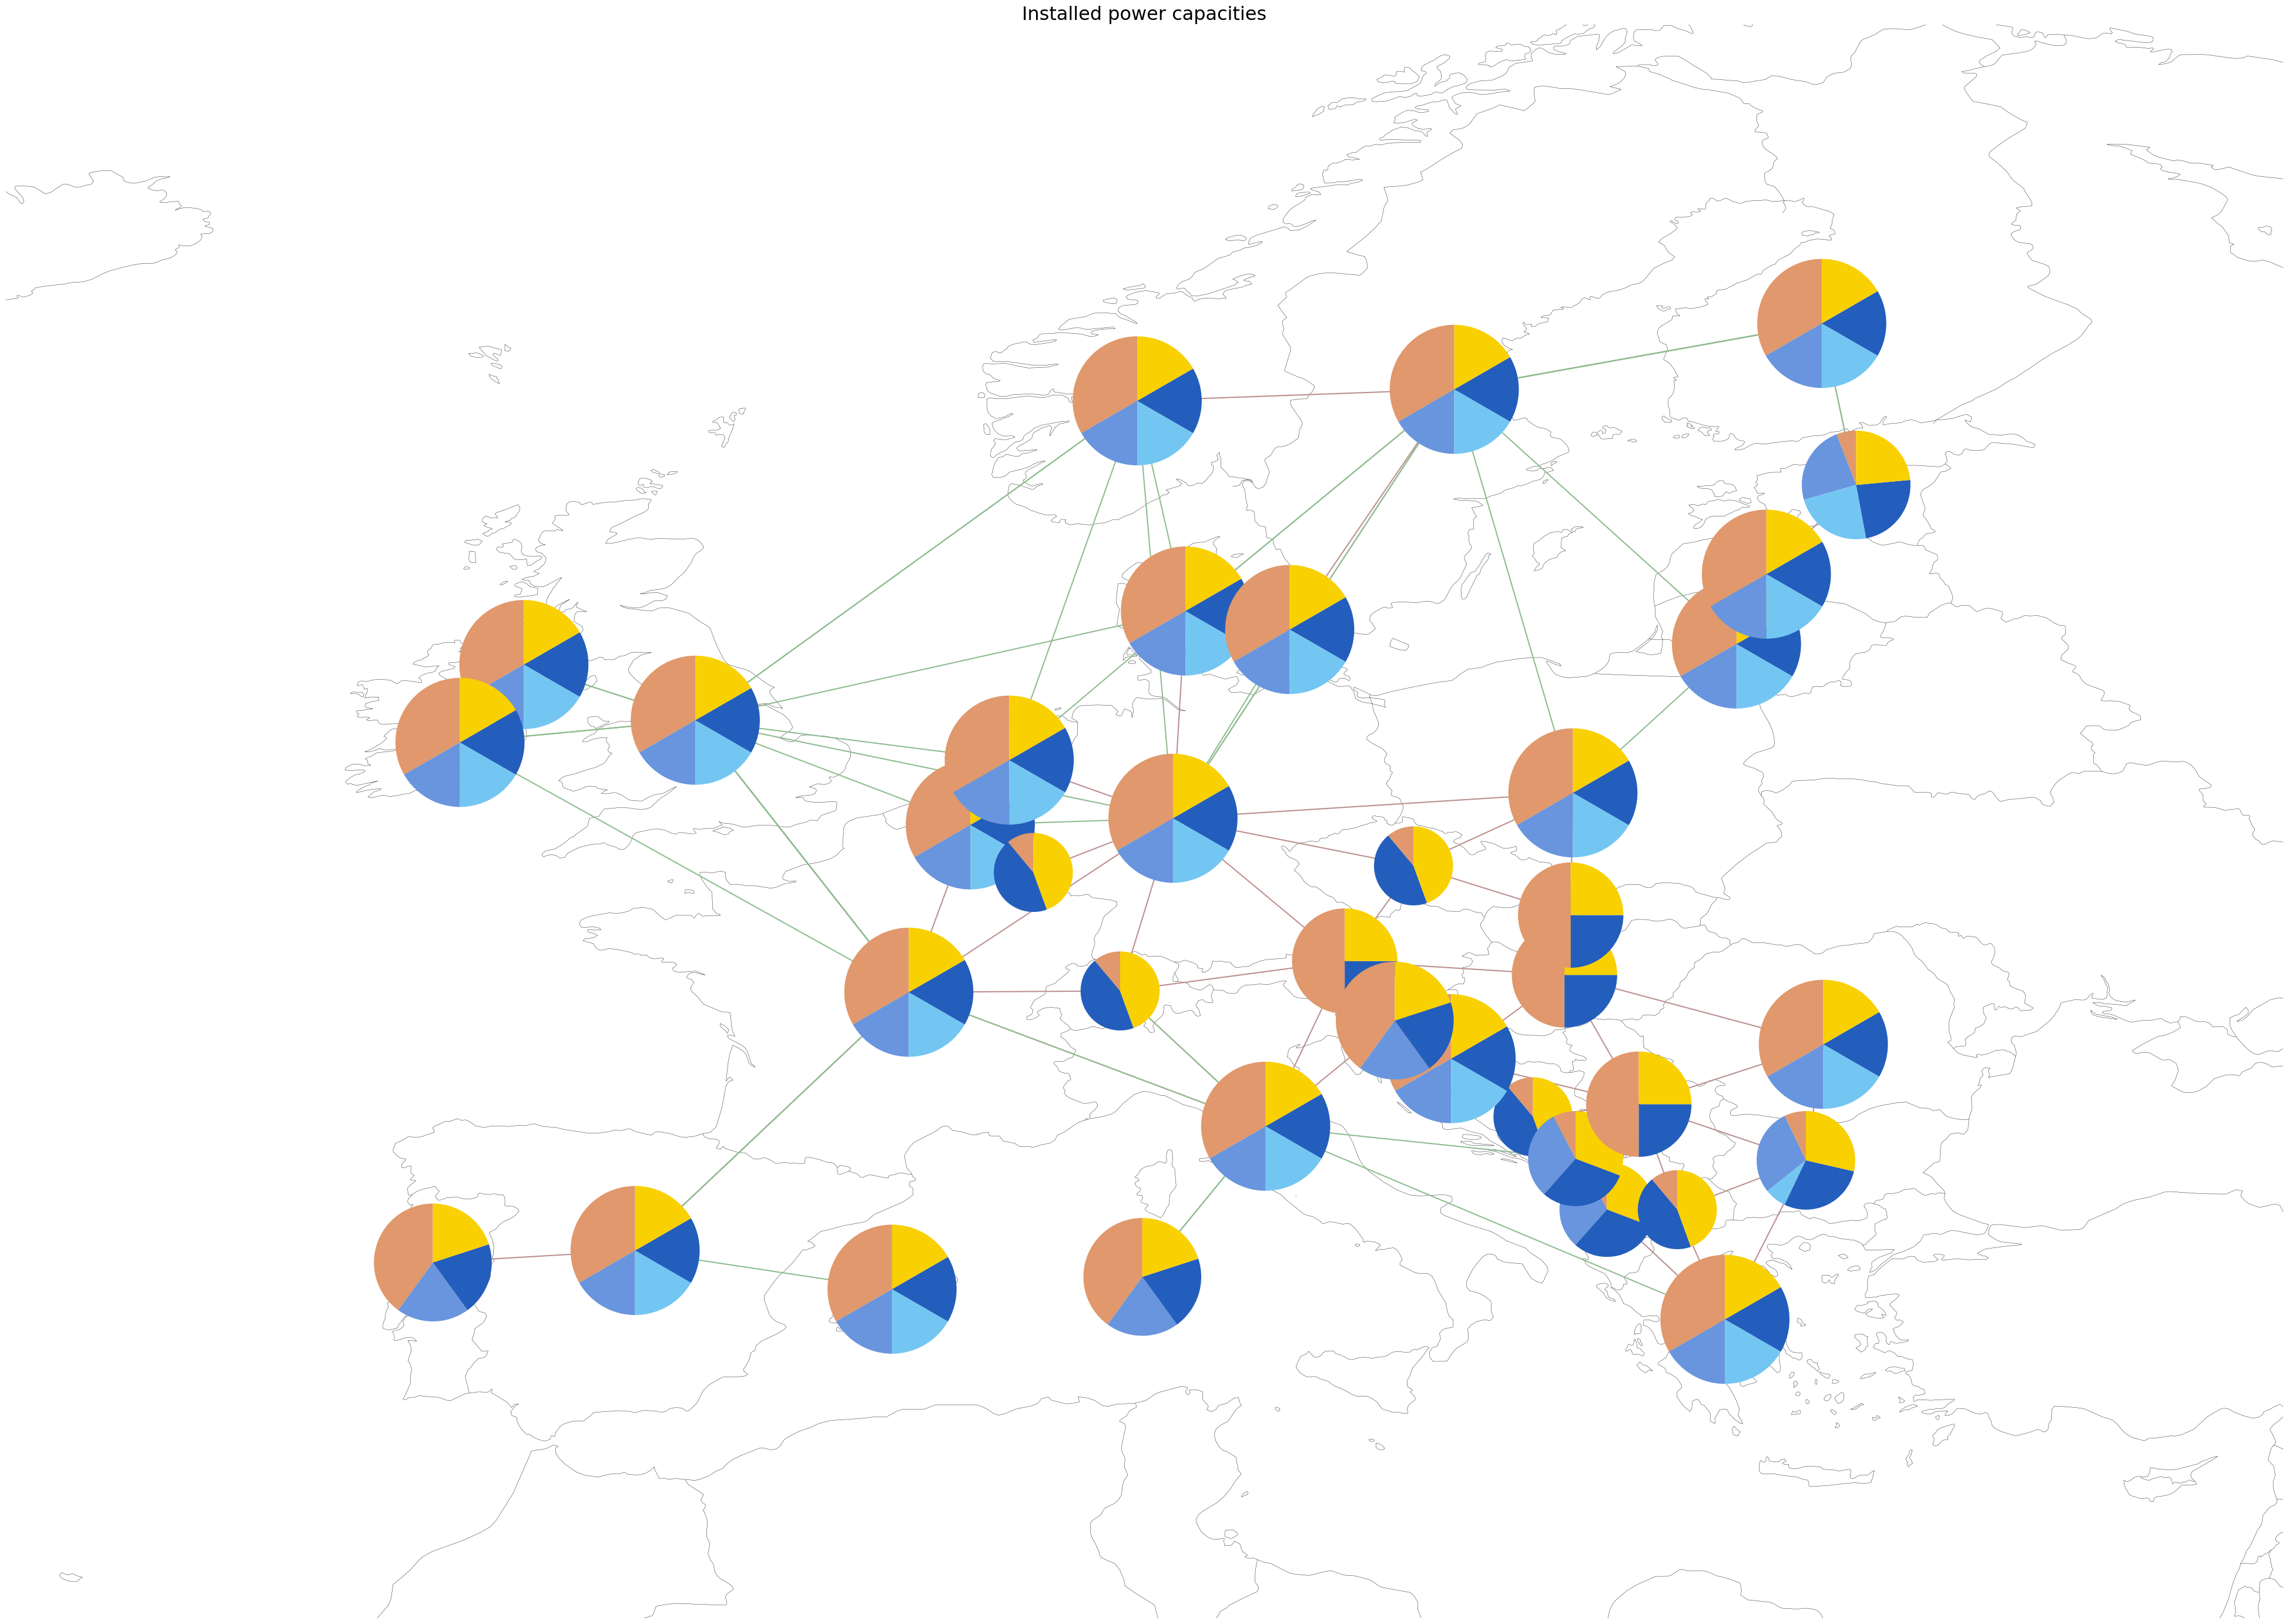

In [20]:
inst_cap_plot()

In [33]:
gen = n.generators
carrier = gen.carrier.unique()
def gen_power_table(colors):

    df_tot_generation = n.generators_t.p.sum()

    generations = pd.Series(index = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

    for r in region:
        for tech in carrier:
            key = f"{r} {tech}"
            if key in df_tot_generation.index:
                try:
                    generations.loc[r, tech] = df_tot_generation[key]
                except KeyError:
                    print('error')

    plt.figure()
    plt.rcParams.update({'font.size': 16})

    (generations.unstack()/1000).plot.bar(figsize=(17,10),
                                stacked=True,
                                color=colors,
                                grid=True,
                                xlabel="",
                                ylabel="Generated electricity [GWh]",
                                #title=f"Generated electricity in Italy in {year}"
    )

    plt.show()

29.2

<Figure size 640x480 with 0 Axes>

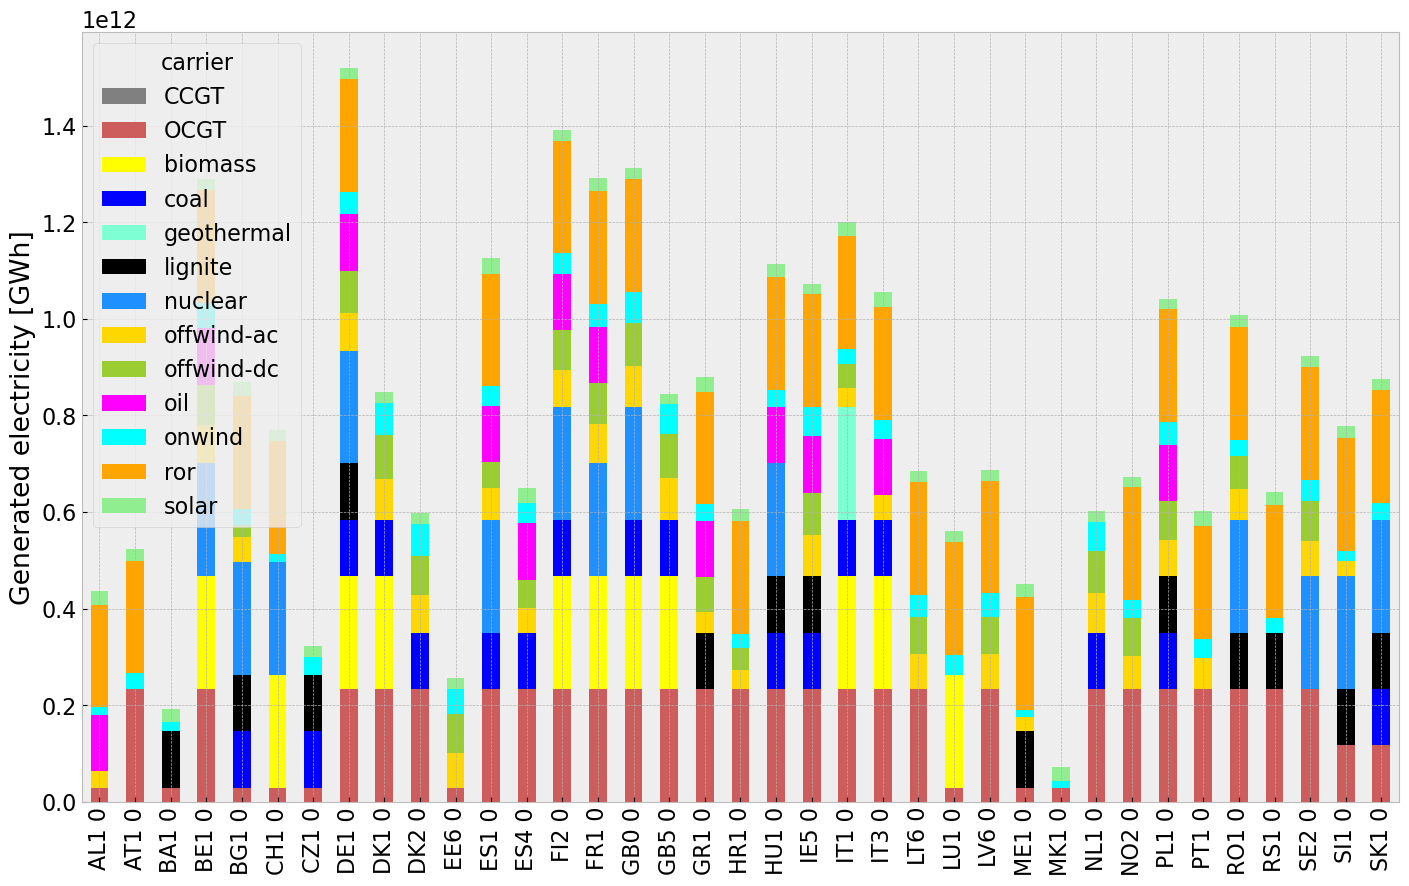

In [22]:
colors = [
    "grey", "indianred", "yellow", "blue", "aquamarine",
    "black", "dodgerblue", "gold", "yellowgreen", "magenta",
    "cyan", "orange", "lightgreen"
]

gen_power_table(colors)

In [24]:
def inst_cap_table(colors,gen):

    capacities = gen.groupby(['bus', 'carrier']).p_nom_opt.sum()
    capacities.fillna(0, inplace=True)

    plt.figure()
    plt.rcParams.update({'font.size': 16})

    (capacities.unstack()/1000).plot.bar(figsize=(17,10),
                                stacked=True,
                                color=colors,
                                grid=True,
                                xlabel="",
                                ylabel="Installed capacity [GW]",
                                title=f"Installed power capacity"
    )

    plt.show()

<Figure size 640x480 with 0 Axes>

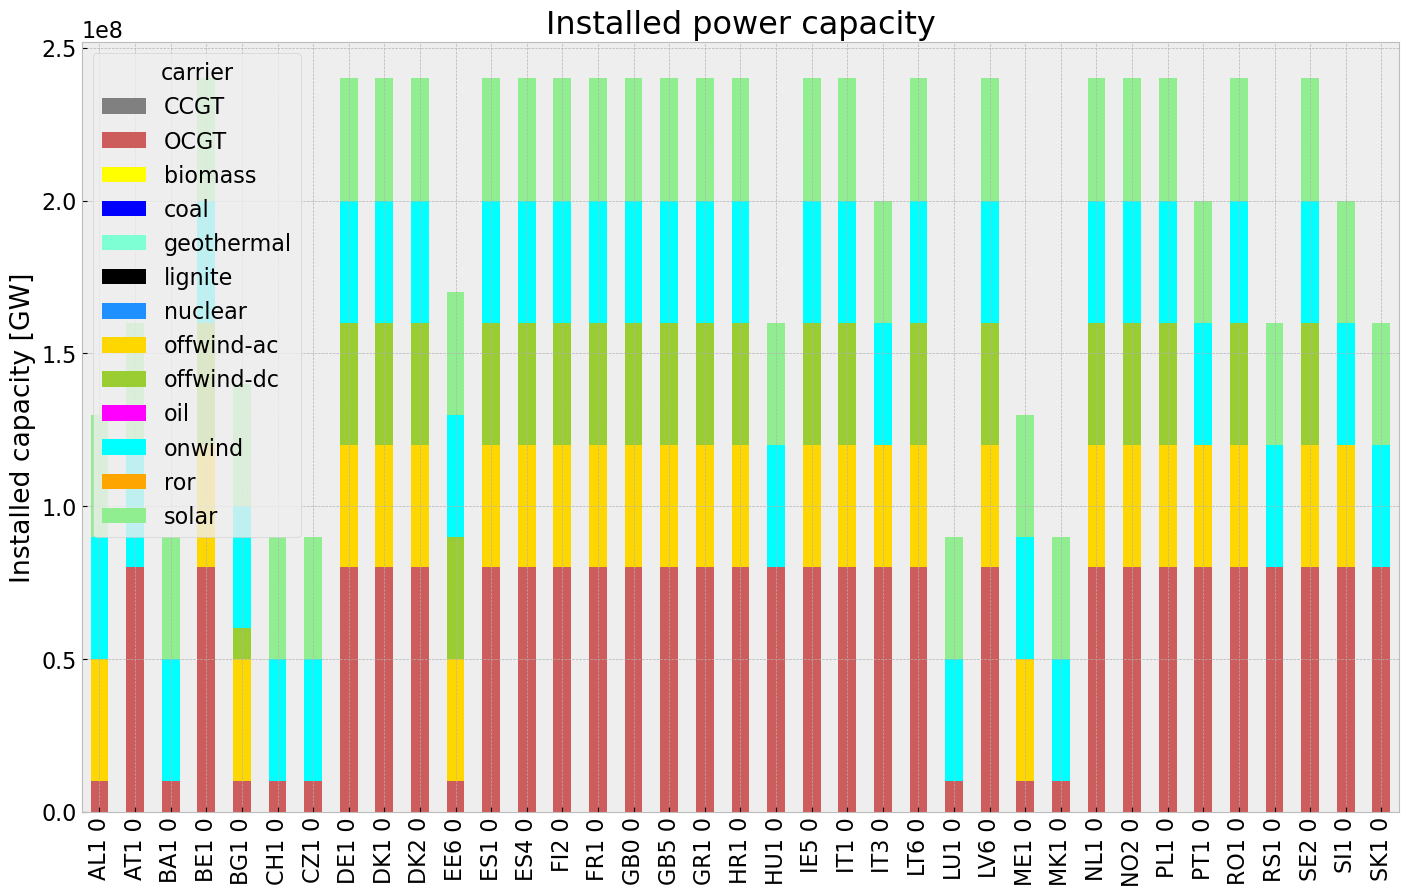

In [59]:
gen = n.generators
inst_cap_table(colors,gen)

In [106]:
def gen_curve_month_summer(colors):

    plt.rcParams.update({'font.size': 16})

    time="2013-03"

    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
    
    fig, ax = plt.subplots(figsize=(14, 10))
        
    p_by_carrier.where(p_by_carrier>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=colors,
        grid=True,

    )
    
    charge = p_by_carrier.where(p_by_carrier<0).dropna(how='all', axis=1).loc[time]
    
    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=["yellowgreen", "magenta"],
            grid=True,
        )
    
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k',grid=True)

    plt.legend(loc=(1.05,0))
    
    ax.set_ylabel("Power [GW]")
    ax.set_title(f"Hourly electricity production")


    ax.set_ylim(-1e10, 2e10)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_5536\3651072260.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_5536\3651072260.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)


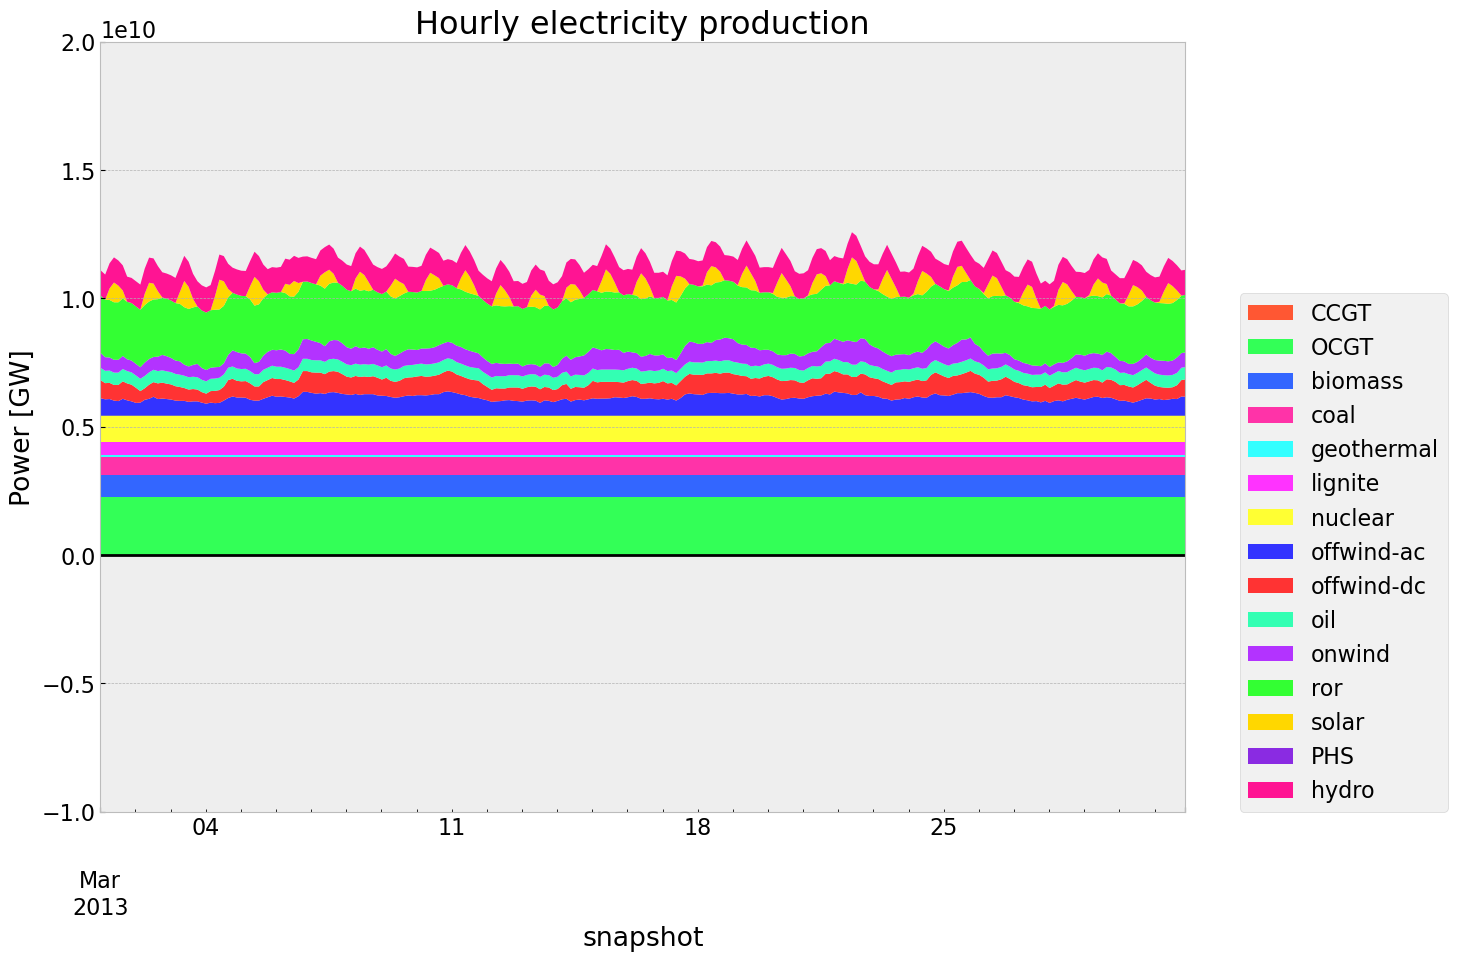

In [107]:
colors_15 = ["#FF5733", "#33FF57", "#3366FF", "#FF33A8", "#33FFFF", "#FF33FF", "#FFFF33", "#3333FF", "#FF3333", "#33FFB3", "#B333FF", "#33FF33", "#FFD700", "#8A2BE2", "#FF1493"]

gen_curve_month_summer(colors_15)

## Demand

In [63]:
#display demand
#n.loads_t.p_set.div(1e3).plot(figsize=(50,50), ylabel="GW")

In [56]:
n.loads_t.p_set.sum(axis=1).loc['2013-03'].div(1e3)

snapshot
2013-03-01 00:00:00    353.151961
2013-03-01 03:00:00    371.499782
2013-03-01 06:00:00    458.840140
2013-03-01 09:00:00    474.198411
2013-03-01 12:00:00    454.963749
                          ...    
2013-03-31 09:00:00    349.287426
2013-03-31 12:00:00    325.077545
2013-03-31 15:00:00    334.431510
2013-03-31 18:00:00    364.912182
2013-03-31 21:00:00    326.689998
Length: 248, dtype: float64

## Storage

In [79]:
def inst_store_table():
    
    plt.rcParams.update({'font.size': 16})

    (n.storage_units.groupby(['bus','carrier']).p_nom_opt.sum().unstack()/1000).plot.bar(figsize=(17,10),
                                stacked=True,
                                color=["yellowgreen","magenta"],
                                grid=True,
                                xlabel="",
                                ylabel="Installed capacity [GW]",
                                #title=f"Installed power capacities of storage systems in Italy in {year}",
                                ylim=[0,50]
    )

    return n.storage_units.groupby(['bus','carrier']).p_nom_opt.sum().unstack()/1000

carrier,PHS,hydro
bus,,
AL1 0,NaN,1.690700
AT1 0,5.057300,3.600620
BA1 0,0.440000,1.614500
BE1 0,1.308000,0.012783
BG1 0,0.864000,1.925140
CH1 0,5.089550,9.916310
DE1 0,7.599220,0.289500
ES1 0,8.870750,14.975837
FI2 0,NaN,1.295900


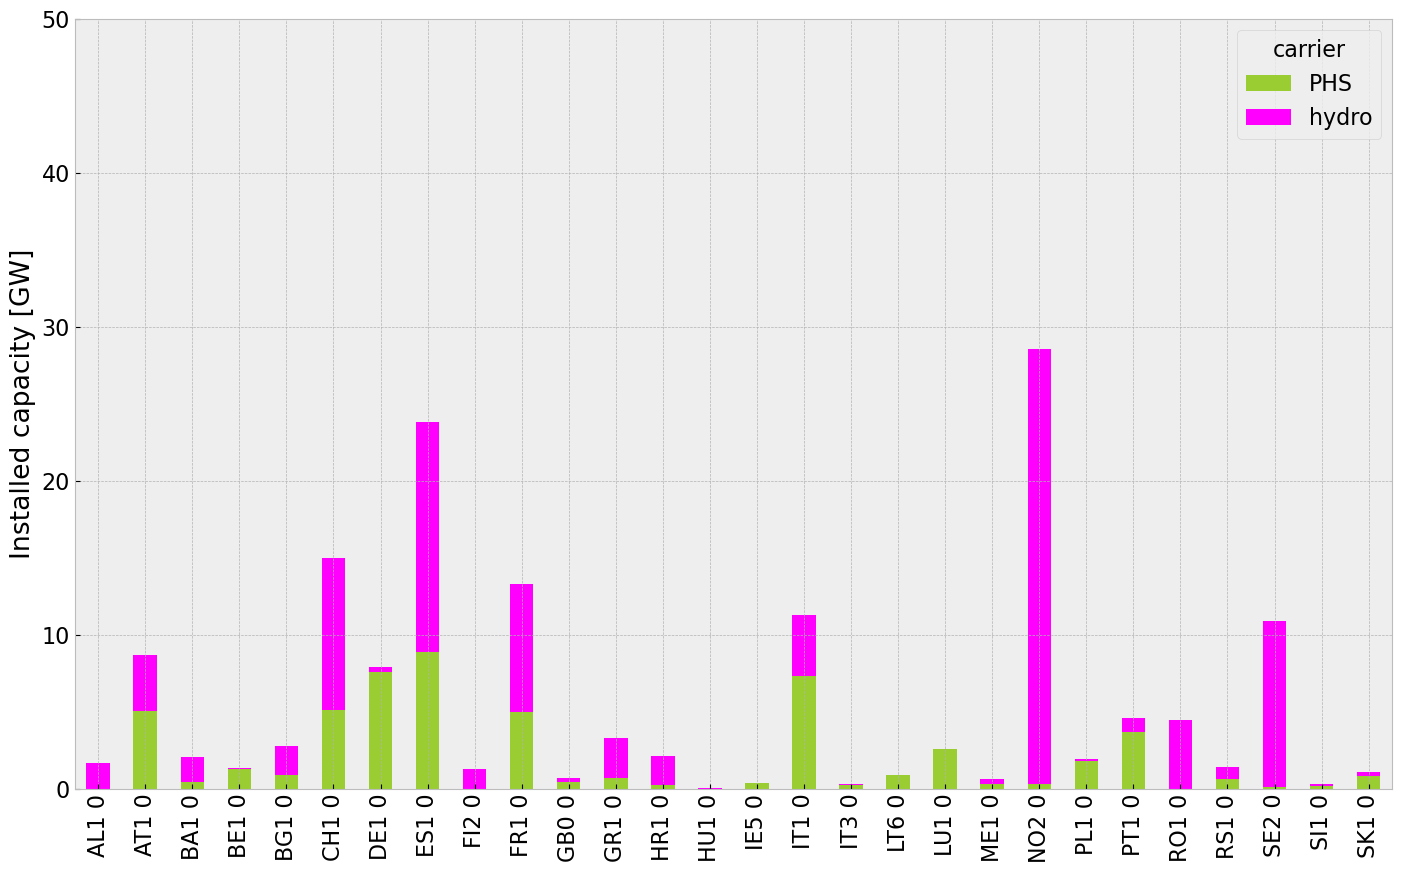

In [80]:
inst_store_table()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_5536\1019775463.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)


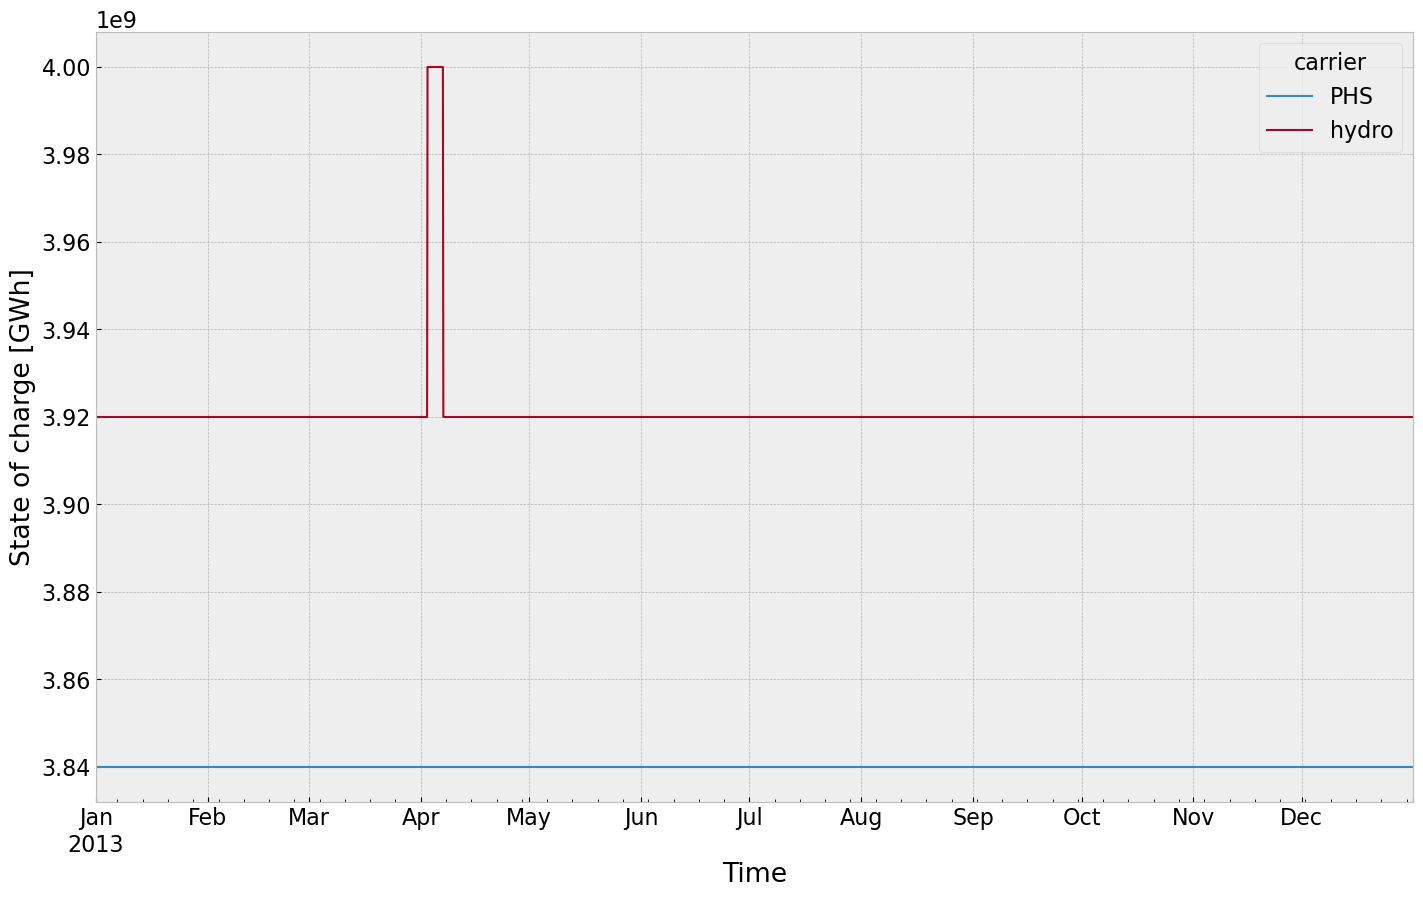

In [101]:
def state_of_charge_plot():
    
    soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)

    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(17,10))

    soc.plot(ax=ax,
        grid=True,
        ylabel="State of charge [GWh]",
        xlabel="Time",
        #title=f"State of charge of aggregated storage systems in Italy in {year}",
        linewidth=1.5,
)

plt.show()
state_of_charge_plot()

# Germany 
## Installed Capacity

In [30]:
country_code = 'DE'
gen_DE = n.generators[n.generators.index.str.startswith(country_code)]
gen_DE.head()

,carrier,bus,p_nom_min,p_nom,p_nom_extendable,efficiency,marginal_cost,capital_cost,p_nom_max,p_max_pu,...,marginal_cost_quadratic,lifetime,committable,start_up_cost,shut_down_cost,stand_by_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
DE1 0 CCGT,CCGT,DE1 0,0.000000,0.000000,False,0.580000,46.812758,104788.020783,inf,1.0,...,0.0,inf,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
DE1 0 OCGT,OCGT,DE1 0,22888.536500,22888.536500,True,0.501555,55.115708,47718.670564,inf,1.0,...,0.0,inf,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
DE1 0 biomass,biomass,DE1 0,8004.647826,8004.647826,False,0.468000,15.838314,294201.051170,inf,1.0,...,0.0,inf,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
DE1 0 coal,coal,DE1 0,8158.220129,8158.220129,False,0.329804,32.243151,337208.027448,inf,1.0,...,0.0,inf,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
DE1 0 geothermal,geothermal,DE1 0,0.000000,0.000000,False,1.000000,0.010850,0.000000,inf,1.0,...,0.0,inf,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0


<Figure size 640x480 with 0 Axes>

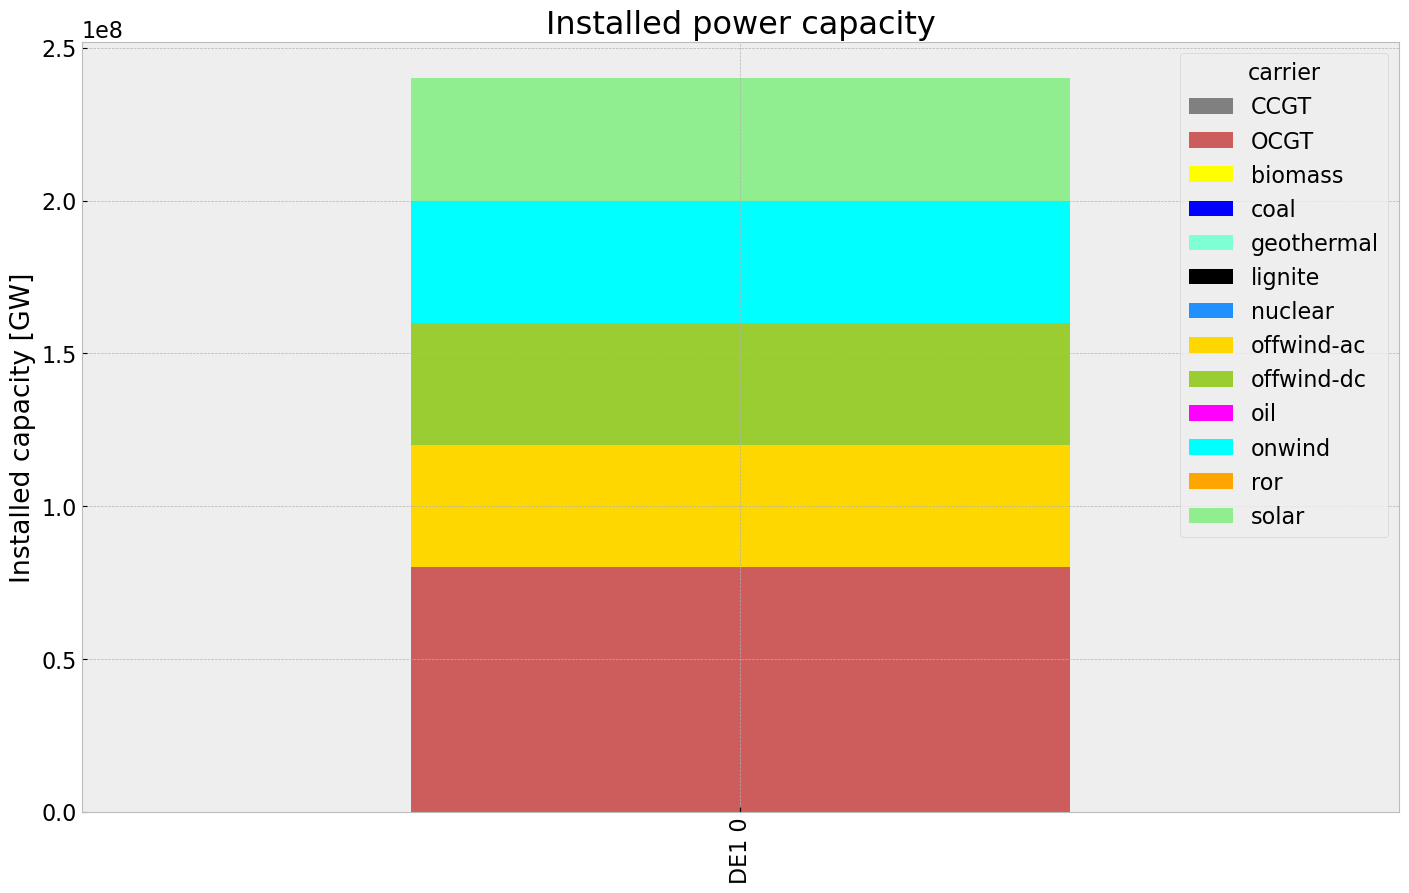

In [48]:
inst_cap_table(colors,gen_DE)

## Generations

<Figure size 640x480 with 0 Axes>

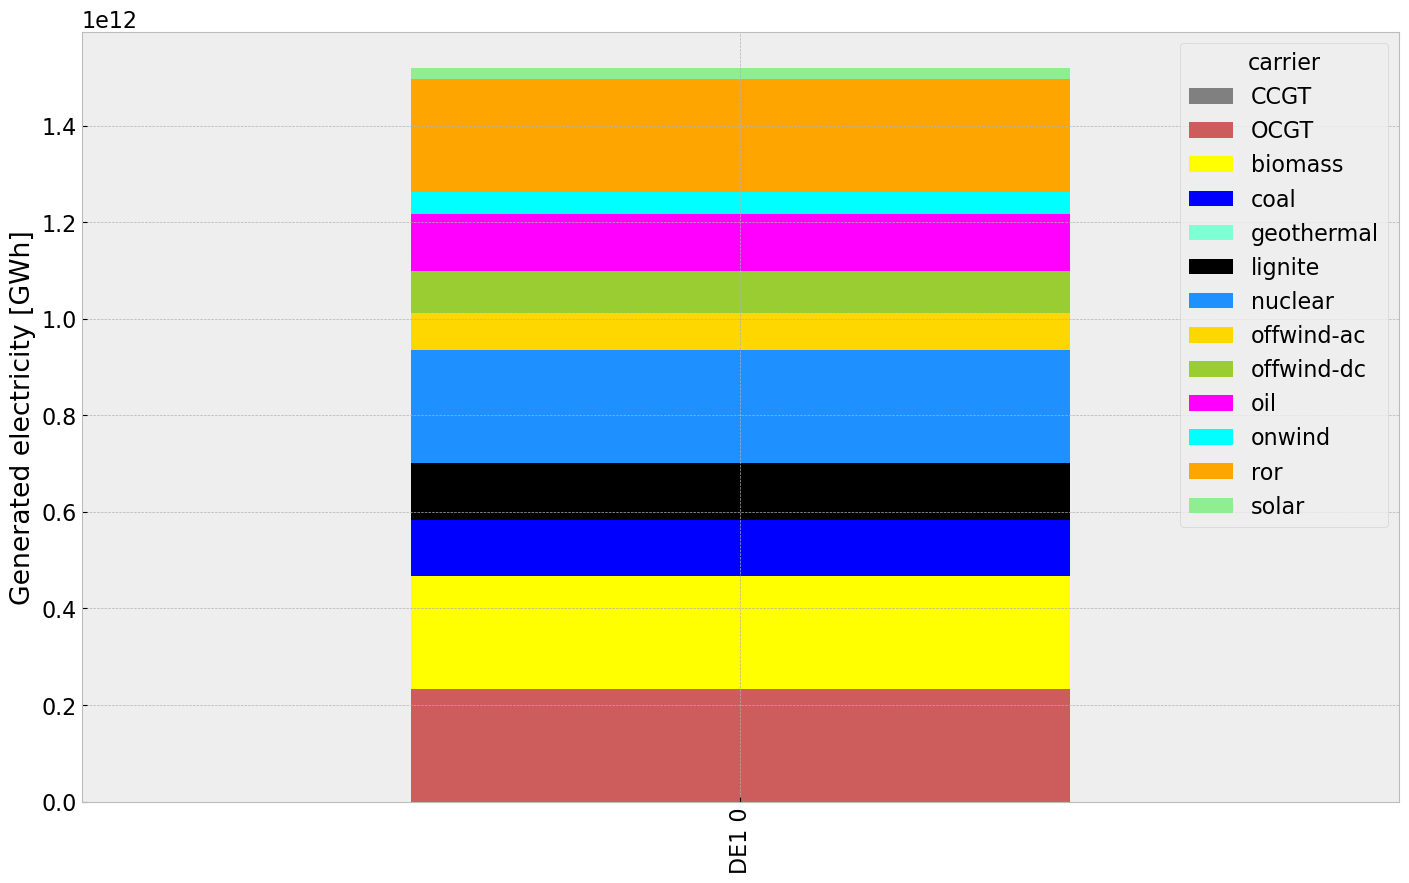

In [53]:
    df_tot_generation = n.generators_t.p.sum()

    generations = pd.Series(index = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

    for r in region:
        for tech in carrier:
            key = f"{r} {tech}"
            if key in df_tot_generation.index:
                try:
                    generations.loc[r, tech] = df_tot_generation[key]
                except KeyError:
                    print('error')

generations = generations.unstack().div(1000)
generations_DE = generations[generations.index.str.startswith(country_code)]#selected country's generation composition in GWh

plt.figure()
    plt.rcParams.update({'font.size': 16})

    generations_DE.plot.bar(figsize=(17,10),
                                stacked=True,
                                color=colors,
                                grid=True,
                                xlabel="",
                                ylabel="Generated electricity [GWh]",
                                #title=f"Generated electricity in Italy in {year}"
    )

    plt.show()